In [1]:
import sys
sys.path.append('../')

import numpy as np
from zephyr.backend import MiniZephyrHD
from zephyr.middleware import Helm2DViscoProblem, Helm2DSurvey, HelmFields
from SimPEG.DataMisfit import l2_DataMisfit

In [2]:
nx = 100
nz = 200
cBackground = 2500.
cAnomaly = -500.

cTrue = cBackground * np.ones((nz,nx))
cTrue[(nz/2)-10:(nz/2)+10,(nx/2)-10:(nx/2)+10] += cAnomaly

sz = np.arange(25, nz-24, 1)
sx = 25. * np.ones((len(sz),))
rz = np.arange(25, nz-24, 1)
rx = (nx - 25.) * np.ones((len(rz),))

geom = {
    'src':      np.vstack([sx, sz]).T,
    'rec':      np.vstack([rx, rz]).T,
}

systemConfig = {
    'dx':       1.,                     # m
    'dz':       1.,                     # m
    'c':        cTrue,                  # m/s
    'rho':      1.,                     # kg/m^3
    'nx':       nx,                     # count
    'nz':       nz,                     # count
    'freqs':    np.arange(50, 450, 50), # Hz
    'Disc':     MiniZephyrHD,           # discretization
    'geom':     geom,                   # dictionary
    'nWorkers': 4,
}

In [3]:
problem = Helm2DViscoProblem(systemConfig)
survey  = Helm2DSurvey(systemConfig)
problem.pair(survey)

In [4]:
dObs = survey.dpred()
survey.dobs = dObs
survey.std = 1.
misfit = l2_DataMisfit(survey)
misfit.Wd = 1.

In [5]:
resid = survey.residual(cBackground)
g = misfit.evalDeriv(cBackground)

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
dObsr = dObs.reshape((survey.nrec, survey.nsrc, survey.nfreq))
residr = resid.reshape(dObsr.shape)

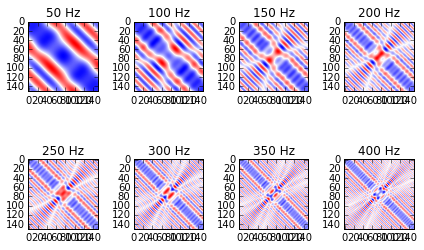

In [8]:
fig = figure()

plotOpts = {
    'cmap': cm.bwr,
}

for ifreq in xrange(8):
    freq = systemConfig['freqs'][ifreq]
    subplot(2, 4, ifreq+1)
    imshow(dObsr[:,:,ifreq].real, **plotOpts)
    title('%d Hz'%(freq,))

fig.tight_layout()

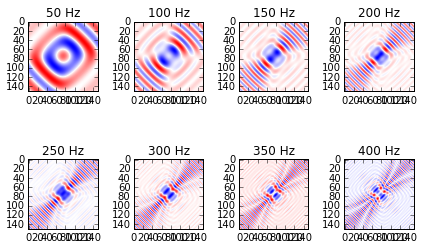

In [9]:
fig = figure()

plotOpts = {
    'cmap': cm.bwr,
}

for ifreq in xrange(8):
    freq = systemConfig['freqs'][ifreq]
    subplot(2, 4, ifreq+1)
    imshow(residr[:,:,ifreq].real, **plotOpts)
    title('%d Hz'%(freq,))

fig.tight_layout()

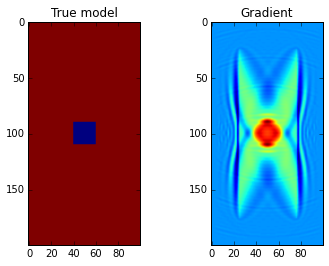

In [10]:
fig = figure()

plotOpts = {
    'cmap': cm.jet,
}

subplot(1,2,1)
imshow(cTrue, **plotOpts)
title('True model')

subplot(1,2,2)
imshow(g.reshape((200,100)).real, **plotOpts)
title('Gradient')